<a href="https://colab.research.google.com/github/seokhee516/kaggle-practice/blob/main/study/Getting_Started_with_a_Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Movies Dataset GCS_DS_PATH = "gs://kds-b8b70c75a3f12c101a2fe788fa7e9e1c8457d0d020f8e60910667880"

In [ ]:
!pip install gcsfs
# TMDB 5000 Movie Dataset
GCS_DS_PATH = "gs://kds-d176ad908f5c997f0b76bab23944366b9b5efb61105eaf194f12d1b7"

In [53]:
 GCS_DS_PATH2 = "gs://kds-b8b70c75a3f12c101a2fe788fa7e9e1c8457d0d020f8e60910667880"

# The Age of Recommender Systems(추천 시스템의 시대)

Demographic Filtering(인구통계학적 필터링) - 영화 인기도 및/또는 장르를 기반으로 모든 사용자에게 일반화된 추천을 제공합니다. 시스템은 유사한 인구 통계학적 특징을 가진 사용자에게 동일한 영화를 추천합니다. 사용자마다 다르기 때문에 이 접근 방식은 너무 단순하다고 간주됩니다. 이 시스템의 기본 아이디어는 더 인기 있고 비평가들의 찬사를 받은 영화가 일반 관객에게 더 좋아질 확률이 더 높다는 것입니다.

Content Based Filtering(콘텐츠 기반 필터링) - 특정 항목을 기반으로 유사한 항목을 제안합니다. 이 시스템은 영화의 장르, 감독, 설명, 배우 등과 같은 항목 메타데이터를 사용하여 이러한 권장 사항을 만듭니다. 이러한 추천 시스템의 이면에 있는 일반적인 아이디어는 사람이 특정 항목을 좋아하면 그와 유사한 항목도 좋아한다는 것입니다.

Collaborative Filtering(협업 필터링) - 이 시스템은 비슷한 관심사를 가진 사람들을 매칭하고 이 매칭을 기반으로 추천을 제공합니다. 협업 필터에는 콘텐츠 기반 필터와 같은 항목 메타데이터가 필요하지 않습니다.

In [2]:
import pandas as pd 
import numpy as np 

df1=pd.read_csv(GCS_DS_PATH+'/tmdb_5000_credits.csv')
df2=pd.read_csv(GCS_DS_PATH+'/tmdb_5000_movies.csv')

### df1 credits
- movie_id - A unique identifier for each movie.
- cast - The name of lead and supporting actors.
- crew - The name of Director, Editor, Composer, Writer etc.

### df2 movies
- budget - The budget in which the movie was made.
- genre - The genre of the movie, Action, Comedy ,Thriller etc.
- homepage - A link to the homepage of the movie.
- id - This is infact the movie_id as in the first dataset.
- keywords - The keywords or tags related to the movie.
- original_language - The language in which the movie was made.
- original_title - The title of the movie before translation or adaptation.
- overview - A brief description of the movie.
- popularity - A numeric quantity specifying the movie popularity.
- production_companies - The production house of the movie.
- production_countries - The country in which it was produced.
- release_date - The date on which it was released.
- revenue - The worldwide revenue generated by the movie.
- runtime - The running time of the movie in minutes.
- status - "Released" or "Rumored".
- tagline - Movie's tagline.
- title - Title of the movie.
- vote_average - average ratings the movie recieved.
- vote_count - the count of votes recieved.

In [3]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

In [4]:
df2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


# Demographic Filtering -
- 영화에 점수를 매기거나 평가하려면 측정항목이 필요합니다. 
- 모든 영화의 점수 계산 점수를 정렬하고 최고 등급의 영화를 사용자에게 추천합니다.

영화의 평균 평점을 점수로 사용할 수는 있지만 평균 평점이 8.9이고 3표만 있는 영화가 평균 평점인 7.8이지만 40표인 영화보다 낫다고 볼 수 없기 때문에 이것을 사용하는 것은 충분히 공정하지 않습니다. 그래서 저는 다음과 같이 주어진 IMDB의 가중 등급(wr)을 사용할 것입니다.


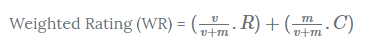

- v는 영화에 대한 투표 수입니다.
- m은 차트에 나열되는 데 필요한 최소 투표수입니다.
- R은 영화의 평균 등급입니다.
- C는 전체 보고서의 평균 투표수입니다.

In [5]:
C= df2['vote_average'].mean()
C

6.092171559442011

모든 영화의 평균 평점은 10점 만점에 약 6점입니다.

In [6]:
m= df2['vote_count'].quantile(0.9)
m

1838.4000000000015

백분위수 90을 컷오프로 사용합니다. 즉, 영화가 차트에 오르려면 목록에 있는 영화의 90% 이상을 득표해야 합니다.

In [7]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

In [8]:
# Weighted Rating 함수 정의
def weighted_rating(x, m=m, C=C):
  v = x['vote_count']
  R = x['vote_average']
  return (v/(v+m) * R) + (m/(m+v) * C)

In [9]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [10]:
# 위에서 계산한 점수를 기준으로 영화 정렬
q_movies = q_movies.sort_values('score', ascending=False)

# top 10 영화 출력
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Text(0.5, 1.0, 'Popular Movies')

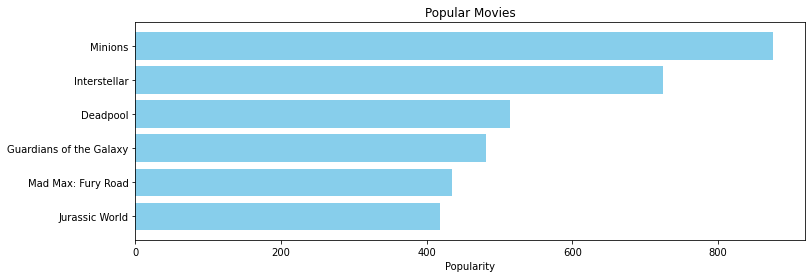

In [11]:
# 인기도 열을 기준으로 데이터세트를 정렬
# 질문 - 왜 굳이 위에 추천 스코어를 구하고 인기도 기준으로 시각화 정렬한건지?
pop = df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

인구통계학적 추천은 모든 사용자에게 일반적인 추천만 제공할 뿐, 특정 사용자 취향에 맞춰주지는 않는다.

# Content Based Filtering
이 추천 시스템에서 영화의 내용(개요, 출연진, 제작진, 키워드, 태그라인 등)은 다른 영화와의 유사성을 찾는 데 사용됩니다. 그런 다음 가장 유사할 가능성이 높은 영화를 추천합니다.



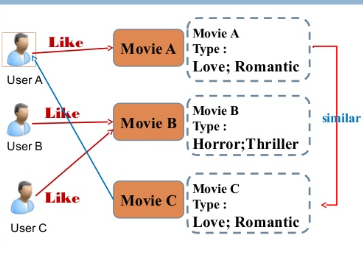

## Plot description based Recommender
줄거리 설명을 기반으로 모든 영화에 대한 쌍별 유사성 점수를 계산하고 유사성 점수를 기반으로 영화를 추천합니다. 플롯 설명은 데이터 세트의 개요 기능에 나와 있습니다. 데이터를 살펴보자

In [12]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

이제 각 개요에 대한 TF-IDF(Term Frequency-Inverse Document Frequency) 벡터를 계산합니다.

In [13]:
df2['overview'].isnull().sum()

3

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

# 결측값 제거
df2['overview'] = df2['overview'].fillna('')

# TF-IDF 매트릭스 생성 
tfidf_matrix = tfidf.fit_transform(df2['overview'])

tfidf_matrix.shape

(4803, 20978)

데이터 세트에서 4800개의 영화를 설명하는 데 20,000개 이상의 다른 단어가 사용되었음을 알 수 있습니다.

이 행렬을 사용하여 이제 유사성 점수를 계산할 수 있습니다. 우리는 코사인 유사성을 사용하여 두 영화 간의 유사성을 나타내는 숫자 수량을 계산할 것입니다. 코사인 유사성을 사용하여 두 영화 간의 유사성을 나타내는 숫자 수량을 계산할 것입니다. 코사인 유사도 점수는 크기와 무관하고 계산이 비교적 쉽고 빠르기 때문에 사용합니다. 수학적으로는 다음과 같이 정의됩니다.

TF-IDF 벡터라이저를 사용했기 때문에 내적을 계산하면 코사인 유사성 점수가 직접 제공됩니다. 따라서 cosine_similarities() 대신 sklearn의 linear_kernel()이 더 빠르기 때문에 사용합니다.

In [15]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [16]:
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.02160533, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01488159, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02160533, 0.01488159, ..., 1.        , 0.01609091,
        0.00701914],
       [0.        , 0.        , 0.        , ..., 0.01609091, 1.        ,
        0.01171696],
       [0.        , 0.        , 0.        , ..., 0.00701914, 0.01171696,
        1.        ]])

영화 제목을 입력으로 받아 가장 유사한 10개의 영화 목록을 출력하는 함수를 정의할 것입니다. 먼저 이를 위해 영화 제목과 DataFrame 인덱스의 역 매핑이 필요합니다. 다시 말해, 제목이 주어지면 메타데이터 DataFrame에서 영화의 인덱스를 식별하는 메커니즘이 필요합니다.

In [17]:
# 인덱스와 영화 제목의 역 맵 구성
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()
indices

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

이제 추천 기능을 정의하는 단계입니다.

- 제목이 지정된 영화의 인덱스를 가져옵니다.
- 모든 영화와 함께 특정 영화에 대한 코사인 유사도 점수 목록을 가져옵니다. 첫 번째 요소가 위치이고 두 번째 요소가 유사성 점수인 튜플 목록으로 변환합니다.
- 유사성 점수를 기반으로 앞서 언급한 튜플 목록을 정렬합니다. 즉, 두 번째 요소입니다.
- 이 목록의 상위 10개 요소를 가져옵니다. 첫 번째 요소는 self를 나타내므로 무시하십시오(특정 영화와 가장 유사한 영화는 영화 자체임).
- 상위 요소의 인덱스에 해당하는 제목을 반환합니다.

In [18]:
# 영화 제목을 입력받아 가장 유사한 영화를 출력하는 기능
def get_recommendations(title, cosine_sim=cosine_sim):
  # 제목과 일치하는 영화의 인덱스 가져오기
  idx = indices[title]
  
  # 해당 영화와 함께 모든 영화의 쌍별 유사도 점수
  sim_scores = list(enumerate(cosine_sim[idx]))

  # 유사도 큰 순 정력
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  # 가장 유사한 10개
  sim_scores = sim_scores[1:11]

  # 인덱스
  movie_indices = [i[0] for i in sim_scores]

  # 타이틀 리턴
  return df2['title'].iloc[movie_indices]

In [24]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

우리 시스템은 유사한 줄거리 설명을 가진 영화를 찾는 데 괜찮은 작업을 수행했지만 권장 사항의 품질은 그리 좋지 않습니다. "다크 나이트 라이즈"는 모든 배트맨 영화를 반환하지만 그 영화를 좋아한 사람들은 다른 크리스토퍼 놀란 영화를 더 즐기는 경향이 있습니다. 이것은 현재 시스템으로 포착할 수 없는 것입니다.

### 결과값

In [19]:
indices['The Dark Knight Rises']

3

In [20]:
list(enumerate(cosine_sim[3]))

[(0, 0.0249951158376727),
 (1, 0.0),
 (2, 0.0),
 (3, 1.0),
 (4, 0.010433403719159354),
 (5, 0.0051446018158107934),
 (6, 0.01260063243546246),
 (7, 0.026954270578912674),
 (8, 0.02065221688538951),
 (9, 0.1337400906655523),
 (10, 0.0),
 (11, 0.0),
 (12, 0.0),
 (13, 0.0),
 (14, 0.0),
 (15, 0.004071333922512107),
 (16, 0.021121093874993183),
 (17, 0.0),
 (18, 0.006768893195007471),
 (19, 0.010765175685064708),
 (20, 0.007178266390761152),
 (21, 0.033380775071488206),
 (22, 0.0),
 (23, 0.0),
 (24, 0.019238168304196293),
 (25, 0.017013388161368177),
 (26, 0.018845673291717265),
 (27, 0.0),
 (28, 0.008351231142809445),
 (29, 0.02582248131068942),
 (30, 0.017549884233472455),
 (31, 0.029947529512076927),
 (32, 0.021708602796233892),
 (33, 0.0),
 (34, 0.0),
 (35, 0.0),
 (36, 0.028418448812136628),
 (37, 0.0),
 (38, 0.030631547964966054),
 (39, 0.01088522587631032),
 (40, 0.0),
 (41, 0.021109848007927),
 (42, 0.008087287409335878),
 (43, 0.0),
 (44, 0.0),
 (45, 0.008667206203132952),
 (46, 0.0

In [21]:
sorted(list(enumerate(cosine_sim[3])), key=lambda x: x[1], reverse=True)

[(3, 1.0),
 (65, 0.30151176591665485),
 (299, 0.29857045255396825),
 (428, 0.2878505467001694),
 (1359, 0.264460923827995),
 (3854, 0.18545003006561456),
 (119, 0.16799626199850706),
 (2507, 0.16682891043358278),
 (9, 0.1337400906655523),
 (1181, 0.13219702138476813),
 (210, 0.13045537014449818),
 (879, 0.1050189187666832),
 (2193, 0.10165255714476643),
 (1398, 0.09752654489014094),
 (2416, 0.08489350377316789),
 (1068, 0.0834630551022508),
 (979, 0.0810447942804151),
 (1202, 0.0809702563755767),
 (790, 0.08025680374928534),
 (2274, 0.07599448716850146),
 (1766, 0.07120865991897887),
 (1143, 0.07065258392103324),
 (1698, 0.07064108280814063),
 (1492, 0.07036488820561998),
 (1349, 0.06984391781897388),
 (286, 0.06866383939743481),
 (4649, 0.06866005065600596),
 (590, 0.06691123930989949),
 (2094, 0.06645676806735812),
 (2850, 0.06496959163248528),
 (614, 0.06410355106132812),
 (1984, 0.06369601457967806),
 (2035, 0.06186460478967933),
 (1246, 0.06172921709267419),
 (2638, 0.061693135314

In [22]:
sorted(list(enumerate(cosine_sim[3])), key=lambda x: x[1], reverse=True)[1:11]

[(65, 0.30151176591665485),
 (299, 0.29857045255396825),
 (428, 0.2878505467001694),
 (1359, 0.264460923827995),
 (3854, 0.18545003006561456),
 (119, 0.16799626199850706),
 (2507, 0.16682891043358278),
 (9, 0.1337400906655523),
 (1181, 0.13219702138476813),
 (210, 0.13045537014449818)]

In [23]:
[i[0] for i in sorted(list(enumerate(cosine_sim[3])), key=lambda x: x[1], reverse=True)[1:11]]

[65, 299, 428, 1359, 3854, 119, 2507, 9, 1181, 210]

## Credits, Genres and Keywords Based Recommender

메타데이터를 사용하면 추천자의 품질이 향상될 것입니다. 이것이 바로 이 섹션에서 우리가 할 일입니다. 탑 배우 3인, 감독, 관련 장르, 영화 줄거리 키워드 등의 메타데이터를 기반으로 추천기를 구축할 예정입니다.

출연진, 제작진 및 키워드 기능에서 가장 중요한 세 배우, 감독 및 해당 영화와 관련된 키워드를 추출해야 합니다.

In [25]:
# 의견 : literal_eval 사용하여 리스트로 바꿔줌
from ast import literal_eval
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)
    print(df2[feature])

0       [{'cast_id': 242, 'character': 'Jake Sully', '...
1       [{'cast_id': 4, 'character': 'Captain Jack Spa...
2       [{'cast_id': 1, 'character': 'James Bond', 'cr...
3       [{'cast_id': 2, 'character': 'Bruce Wayne / Ba...
4       [{'cast_id': 5, 'character': 'John Carter', 'c...
                              ...                        
4798    [{'cast_id': 1, 'character': 'El Mariachi', 'c...
4799    [{'cast_id': 1, 'character': 'Buzzy', 'credit_...
4800    [{'cast_id': 8, 'character': 'Oliver O’Toole',...
4801    [{'cast_id': 3, 'character': 'Sam', 'credit_id...
4802    [{'cast_id': 3, 'character': 'Herself', 'credi...
Name: cast, Length: 4803, dtype: object
0       [{'credit_id': '52fe48009251416c750aca23', 'de...
1       [{'credit_id': '52fe4232c3a36847f800b579', 'de...
2       [{'credit_id': '54805967c3a36829b5002c41', 'de...
3       [{'credit_id': '52fe4781c3a36847f81398c3', 'de...
4       [{'credit_id': '52fe479ac3a36847f813eaa3', 'de...
                              ..

In [27]:
# literal_eval 문자열을 딕셔너리/리스트 형태로 바꿔줄 수 있다.
a = "['호랑이', '사자', '기린']"
a = literal_eval(a)
print(a)

['호랑이', '사자', '기린']


In [30]:
type(df2[feature][0])

list

필요한 정보만 추출 하는 functions 생성


In [32]:
# 감독 이름 
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [33]:
# 목록 상위 3개 또는 전체 목록
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names

    # 없을 경우 빈값
    return []

In [34]:
df2['director'] = df2['crew'].apply(get_director)

# 배우, 키워드, 장르 정보
features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [35]:
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [36]:
# 모든 문자열을 소문자로 변환하고 공백의 이름을 제거하는 기능
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
      if isinstance(x, str):
        return str.lower(x.replace(" ", ""))
      else:
          return ''

In [37]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

이제 우리는 벡터라이저에 제공하려는 모든 메타데이터(즉, 배우, 감독 및 키워드)를 포함하는 문자열인 "메타데이터 수프"를 생성할 수 있는 위치에 있습니다.

In [38]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)
df2['soup']

0       cultureclash future spacewar samworthington zo...
1       ocean drugabuse exoticisland johnnydepp orland...
2       spy basedonnovel secretagent danielcraig chris...
3       dccomics crimefighter terrorist christianbale ...
4       basedonnovel mars medallion taylorkitsch lynnc...
                              ...                        
4798    unitedstates–mexicobarrier legs arms carlosgal...
4799     edwardburns kerrybishé marshadietlein edwardb...
4800    date loveatfirstsight narration ericmabius kri...
4801       danielhenney elizacoupe billpaxton danielhsia 
4802    obsession camcorder crush drewbarrymore brianh...
Name: soup, Length: 4803, dtype: object

다음 단계는 플롯 설명 기반 추천기로 수행한 것과 동일합니다. 한 가지 중요한 차이점은 TF-IDF 대신 CountVectorizer()를 사용한다는 것입니다. 상대적으로 더 많은 영화에 출연하거나 감독한 배우/감독의 존재를 축소하고 싶지 않기 때문입니다. 별로 직관적이지 않습니다.

의견(*) : TF-IDF의 경우 다른 영화에는 나오지 않고 특정 영화에만 나온 배우/감독.

CountVectorizer의 경우 어떤 영화든지 많이 나온 배우/감독

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [40]:
# 아까는 리니어 커널 썼는데, 지금은 그냥 코사인 유사도..
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [42]:
# 기본 DataFrame의 인덱스를 재설정하고 이전과 같이 역 매핑을 구성합니다.
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [43]:
# 감독 정보까지 추가됨 The Prestige
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

우리는 추천자가 더 많은 메타데이터로 인해 더 많은 정보를 성공적으로 캡처했으며 더 나은 추천을 제공했음을 알 수 있습니다. 마블이나 DC 코믹스 팬들은 같은 제작사의 영화를 좋아할 가능성이 더 큽니다. 따라서 위의 기능에 production_company 를 추가할 수 있습니다. 수프에 기능을 여러 번 추가하여 감독의 가중치를 높일 수도 있습니다.

# Collaborative Filtering

콘텐츠 기반 엔진은 몇 가지 심각한 제한 사항을 겪고 있습니다. 특정 영화에 가까운 영화만 추천할 수 있습니다. 즉, 취향을 포착하고 장르를 초월한 추천을 제공할 수 없습니다.

또한 우리가 구축한 엔진은 사용자의 개인적인 취향과 편견을 포착하지 못한다는 점에서 실제로 개인적인 것이 아닙니다. 영화를 기반으로 한 추천에 대해 우리 엔진에 쿼리하는 사람은 누구인지에 관계없이 해당 영화에 대해 동일한 추천을 받게 됩니다.

따라서 이 섹션에서는 공동 필터링이라는 기술을 사용하여 영화 감상자에게 추천할 것입니다. 기본적으로 두 가지 유형이 있습니다.

### User based filtering
사용자 기반 필터링 - 이 시스템은 유사한 사용자가 좋아하는 사용자에게 제품을 추천합니다. 두 사용자 간의 유사성을 측정하기 위해 피어슨 상관 또는 코사인 유사도를 사용할 수 있습니다. 이 필터링 기술은 예를 들어 설명할 수 있습니다. 다음 행렬에서 각 행은 사용자를 나타내고 열은 해당 사용자와 대상 사용자 간의 유사성을 기록하는 마지막 영화를 제외하고 다른 영화에 해당합니다. 각 셀은 사용자가 해당 영화에 부여한 등급을 나타냅니다. 사용자 E가 대상이라고 가정합니다.

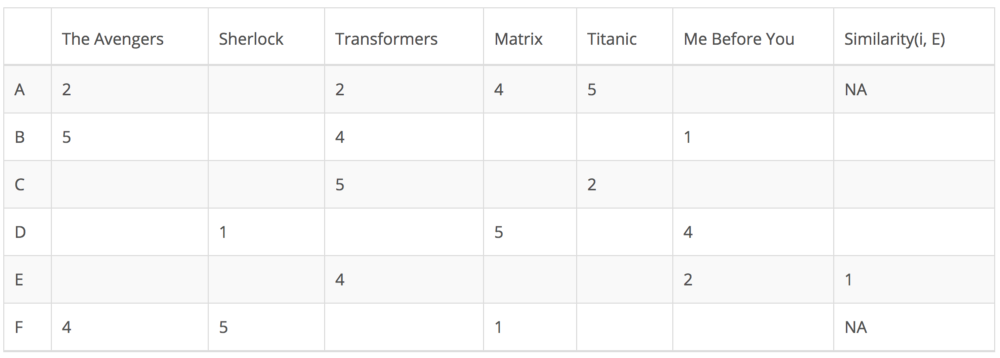

위의 표에서 사용자 D는 사용자 E와 Pearson Correlation이 음수이므로 사용자 E와 매우 다르다는 것을 알 수 있습니다. 그는 Me Before You를 자신의 평균보다 높게 평가했지만 사용자 E는 그 반대였습니다. 이제 사용자 E가 다른 사용자를 기반으로 평가하지 않은 영화의 공백을 채울 수 있습니다.

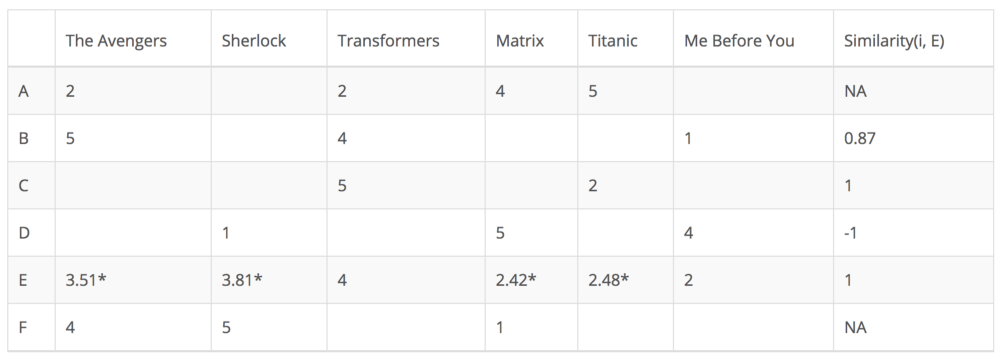

사용자 기반 CF를 계산하는 것은 매우 간단하지만 몇 가지 문제가 있습니다. 한 가지 주요 문제는 사용자의 선호도가 시간이 지남에 따라 변할 수 있다는 것입니다. 인접 사용자를 기반으로 행렬을 미리 계산하면 성능이 저하될 수 있음을 나타냅니다. 이 문제를 해결하기 위해 항목 기반 CF를 적용할 수 있습니다.

### Item Based Collaborative Filtering

아이템 기반 CF는 사용자 간의 유사도를 측정하는 대신 대상 사용자가 평가한 아이템과의 유사도를 기반으로 아이템을 추천합니다. 마찬가지로 유사성은 Pearson Correlation 또는 Cosinesimilarity를 사용하여 계산할 수 있습니다. 주요 차이점은 항목 기반 협업 필터링을 사용하여 사용자 기반 CF가 수행하는 수평 방식과 반대로 공백을 수직으로 채운다는 것입니다. 다음 표는 영화 Me Before You에 대해 그렇게 하는 방법을 보여줍니다.

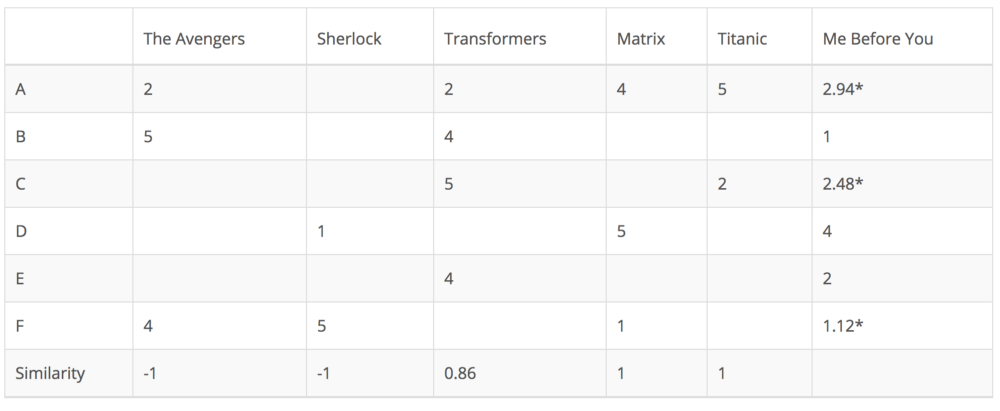

항목 기반 CF가 더 정적이기 때문에 동적 사용자 기본 설정으로 인해 발생하는 문제를 성공적으로 방지합니다. 그러나 이 방법에는 몇 가지 문제가 남아 있습니다. 첫째, 주요 문제는 확장성입니다. 계산은 고객과 제품 모두와 함께 커집니다. 최악의 경우 복잡성은 m명의 사용자와 n개의 항목이 있는 O(mn)입니다. 또한 희소성은 또 다른 문제입니다. 위의 표를 다시 한 번 보세요. Matrix와 Titanic을 모두 평가한 사용자는 단 한 명뿐이지만 둘 사이의 유사도는 1입니다. 극단적인 경우 수백만 명의 사용자가 있을 수 있으며 두 영화의 유사성은 단순히 순위가 비슷하기 때문에 매우 높을 수 있습니다. 둘 다 순위를 매긴 유일한 사용자입니다.

### Single Value Decomposition
CF에 의해 생성된 확장성 및 희소성 문제를 처리하는 한 가지 방법은 잠재 요인 모델을 활용하여 사용자와 항목 간의 유사성을 캡처하는 것입니다. 본질적으로 우리는 추천 문제를 최적화 문제로 바꾸고 싶습니다. 사용자에게 주어진 항목에 대한 평가를 얼마나 잘 예측하는지로 볼 수 있습니다. 하나의 일반적인 메트릭은 RMSE(평균제곱근 오차)입니다. RMSE가 낮을수록 성능이 좋습니다.

이제 잠재 요소에 대해 이야기하면서 그것이 무엇인지 궁금할 것입니다. 사용자나 항목이 가지고 있는 속성이나 개념을 설명하는 광범위한 개념입니다. 예를 들어 음악의 경우 잠재 요소는 음악이 속한 장르를 나타낼 수 있습니다. SVD는 잠재 요인을 추출하여 유틸리티 매트릭스의 차원을 줄입니다. 기본적으로 각 사용자와 각 항목을 차원 r의 잠재 공간에 매핑합니다. 따라서 직접 비교할 수 있는 사용자와 항목 간의 관계를 더 잘 이해하는 데 도움이 됩니다. 아래 그림은 이 아이디어를 보여줍니다.

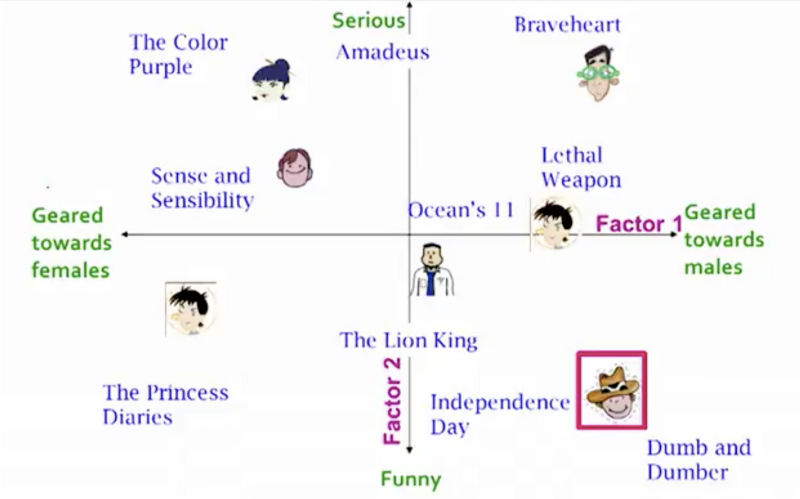

이제 이것을 구현하는 방법을 살펴보겠습니다. 이전에 사용한 데이터셋에는 협업 필터링에 필요한 userId가 없으므로 다른 데이터셋을 불러오도록 하겠습니다. 우리는 SVD를 구현하기 위해 Surprise 라이브러리를 사용할 것입니다.

In [58]:
# 의견 evaluate -> from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
reader = Reader()
ratings = pd.read_csv(GCS_DS_PATH2+'/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [59]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [60]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8983  0.8935  0.8957  0.9006  0.8929  0.8962  0.0029  
MAE (testset)     0.6923  0.6873  0.6897  0.6946  0.6873  0.6902  0.0029  
Fit time          9.17    4.85    4.99    6.68    4.13    5.97    1.81    
Test time         0.25    0.24    0.25    0.13    0.13    0.20    0.06    


{'fit_time': (9.170400381088257,
  4.851365327835083,
  4.985910415649414,
  6.684294939041138,
  4.134605646133423),
 'test_mae': array([0.69228111, 0.68729661, 0.689732  , 0.69463943, 0.6872855 ]),
 'test_rmse': array([0.89826965, 0.89347048, 0.89567775, 0.90055283, 0.89289956]),
 'test_time': (0.24680256843566895,
  0.24412059783935547,
  0.24520492553710938,
  0.1291663646697998,
  0.13161158561706543)}

In [61]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [62]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [63]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.8281129696896103, details={'was_impossible': False})

# Conclusion